# Parsing the TISSUES resource

The TISSUES databse contains tissue-specific gene presence. For more information, see the TISSUES [publication](https://dx.doi.org/10.7717/peerj.1054) or [website](http://tissues.jensenlab.org/Downloads).

In [7]:
# base_url = 'http://download.jensenlab.org/'
# filenames = [
#     'human_tissue_knowledge_filtered.tsv',
#     'human_tissue_knowledge_full.tsv',
#     'human_tissue_experiments_filtered.tsv',
#     'human_tissue_experiments_full.tsv',
#     'human_tissue_textmining_filtered.tsv',
#     'human_tissue_textmining_full.tsv',
#     'human_tissue_integrated_full.tsv',
# ]

# for filename in filenames:
#     ! wget --no-verbose --timestamping --directory-prefix download/ {base_url}/{filename}
#     ! gzip -f download/{filename}

2015-08-07 11:41:05 URL:http://download.jensenlab.org//human_tissue_knowledge_filtered.tsv [4031777/4031777] -> "download/human_tissue_knowledge_filtered.tsv" [1]
2015-08-07 11:41:12 URL:http://download.jensenlab.org//human_tissue_knowledge_full.tsv [22905062/22905062] -> "download/human_tissue_knowledge_full.tsv" [1]
2015-08-07 11:41:27 URL:http://download.jensenlab.org//human_tissue_experiments_filtered.tsv [116379360/116379360] -> "download/human_tissue_experiments_filtered.tsv" [1]
2015-08-07 11:42:04 URL:http://download.jensenlab.org//human_tissue_experiments_full.tsv [413673111/413673111] -> "download/human_tissue_experiments_full.tsv" [1]
2015-08-07 11:42:18 URL:http://download.jensenlab.org//human_tissue_textmining_filtered.tsv [8812695/8812695] -> "download/human_tissue_textmining_filtered.tsv" [1]
2015-08-07 11:42:38 URL:http://download.jensenlab.org//human_tissue_textmining_full.tsv [218252178/218252178] -> "download/human_tissue_textmining_full.tsv" [1]
2015-08-07 11:43:02 

In [52]:
import gzip

import pandas
import pyensembl
import seaborn

%matplotlib inline

## terminology mappings

In [9]:
# Read BTO to Uberon cross-references
url = 'https://raw.githubusercontent.com/dhimmel/uberon/e8dd9247779ba9c419e74ca4ae62e44df92657c3/data/xref.tsv'
uberon_map_df = pandas.read_table(url)
uberon_map_df = uberon_map_df[uberon_map_df.xref.str.startswith('BTO:')]
uberon_map_df = uberon_map_df.rename(columns={'xref': 'bto_id'})

In [30]:
# Read entrez gene mappings
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/xrefs-human.tsv'
entrez_map_df = pandas.read_table(url)    
entrez_map_df = entrez_map_df[entrez_map_df.resource == 'Ensembl']
column_map = {'identifier': 'ensembl_gene_id', 'GeneID': 'entrez_gene_id'}
entrez_map_df = entrez_map_df.rename(columns=column_map)[list(column_map.values())]
entrez_map_df.head()

,entrez_gene_id,ensembl_gene_id
2,1,ENSG00000121410
7,2,ENSG00000175899
11,3,ENSG00000256069
14,9,ENSG00000171428
19,10,ENSG00000156006


In [31]:
# load pyensembl
ensembl = pyensembl.EnsemblRelease(79)

def map_ensembl(ensembl_protein_ids):
    """Returns a dataframe mapping ensembl_protein_ids to entrez_gene_ids."""
    ensembl_proteins = {x for x in ensembl_protein_ids if x.startswith('ENSP')}
    rows = []

    for ensembl_protein in ensembl_proteins:
        try:
            ensembl_gene = ensembl.gene_id_of_protein_id(ensembl_protein)
        except ValueError:
            continue
        rows.append((ensembl_gene, ensembl_protein))
    
    ensembl_df = pandas.DataFrame(rows, columns = ['ensembl_gene_id', 'ensembl_protein_id'])
    map_df = entrez_map_df.merge(ensembl_df)[['entrez_gene_id', 'ensembl_protein_id']]
    map_df = map_df.drop_duplicates()
    return map_df

## dataset formats

Correspondence from Lars Juhl Jensen:

Regarding the file formats, the knowledge and experiments have the following format (columns enumerated):

1. Gene/protein ID (ENSP for proteins, other IDs for ncRNAs)
2. Human readable name for the gene/protein (HGNC gene symbol when available)
3. Brenda Tissue Ontology term
4. Human readable name for the BTO term
5. Source of evidence
6. Association support (can be a GO evidence code, number of ESTs, anything - the original evidence)
7. Confidence score (the score which is shown as stars in the web interface (rounded up on web pages))

The textmining files are a bit different; the first four columns are the same, followed by:
5. Co-occurrence Z-score
6. Confidence score (stars, comparable to other files)
7. Linkout for showing the abstracts that the association is based on


## textmining dataset

In [25]:
column_names = ['ensembl_protein_id', 'gene_symbol', 'bto_id', 'bto_name', 'z-score', 'score', 'sources']
text_df = pandas.read_table('download/human_tissue_textmining_full.tsv.gz', names=column_names)
text_df.head()

,ensembl_protein_id,gene_symbol,bto_id,bto_name,z-score,score,sources
0,5S_rRNA,5S_rRNA,BTO:0001481,Plant,4.614,2.3,http://tissues.jensenlab.org/Entity?documents=...
1,5S_rRNA,5S_rRNA,BTO:0000000,"tissues, cell types and enzyme sources",4.531,2.3,http://tissues.jensenlab.org/Entity?documents=...
2,5S_rRNA,5S_rRNA,BTO:0000964,BTO:0000964,4.286,2.1,http://tissues.jensenlab.org/Entity?documents=...
3,5S_rRNA,5S_rRNA,BTO:0002502,Kinetoplastid,4.150,2.1,http://tissues.jensenlab.org/Entity?documents=...
4,5S_rRNA,5S_rRNA,BTO:0004669,Finger,4.059,2.0,http://tissues.jensenlab.org/Entity?documents=...


## knowledge dataset

In [12]:
column_names = ['ensembl_protein_id', 'gene_symbol', 'bto_id', 'bto_name', 'source', 'evidence', 'score']
knowledge_df = pandas.read_table('download/human_tissue_knowledge_full.tsv.gz', names=column_names)
knowledge_df.head()

,ensembl_id,gene_symbol,bto_id,bto_name,source,evidence,score
0,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",UniProtKB-RC,CURATED,4
1,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",UniProtKB-RC,CURATED,4
2,ENSP00000000233,ARF5,BTO:0000042,Animalic,UniProtKB-RC,CURATED,4
3,ENSP00000000233,ARF5,BTO:0000042,Animalic,UniProtKB-RC,CURATED,4
4,ENSP00000000233,ARF5,BTO:0000081,Reproductive system,UniProtKB-RC,CURATED,4


## experimental dataset

In [13]:
column_names = ['ensembl_protein_id', 'gene_symbol', 'bto_id', 'bto_name', 'source', 'evidence', 'score']
experiment_df = pandas.read_table('download/human_tissue_experiments_full.tsv.gz', names=column_names)
experiment_df.head()

,ensembl_id,gene_symbol,bto_id,bto_name,source,evidence,score
0,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",Exon array,411 intensity units,1
1,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",GNF,103 Intensity units,0
2,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",HPA-RNA,61.1 FPKM,1
3,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",HPM,6 peptides,0
4,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",RNA-seq,2.156 RPKM,0


In [14]:
experiment_summary_df = experiment_df.groupby(['ensembl_id', 'bto_id']).apply(
    lambda df: pandas.Series({
        'count': len(df),
        'mean_score': df.score.mean(),
        'n_3star': sum(df.score >= 3)
    }))

In [15]:
experiment_summary_df.head()

count  mean_score  n_3star
ensembl_id      bto_id                                 
ENSP00000000233 BTO:0000000      6    1.000000        1
                BTO:0000041      1    0.000000        0
                BTO:0000042      6    1.000000        1
                BTO:0000045      1    0.000000        0
                BTO:0000047      3    0.333333        0

## integrated dataset

Correspondence from Lars Juhl Jensen:

> If you go to download.jensenlab.org, you will find that there is also a file called human_tissue_integrated_full.tsv - it is a combined evidence score based on all available evidence. The first four columns are as in the other files; the fifth column contains the combined star confidence score. This file is not yet available via the download webpage, and the scores are not yet used in the web interface. You are welcome to experiment with it if you like, but please bear in mind that this is a test at this stage.

In [40]:
# read dataframe from file
column_names = ['ensembl_protein_id', 'gene_symbol', 'bto_id', 'bto_name', 'score']
integrated_df = pandas.read_table('download/human_tissue_integrated_full.tsv.gz', names=column_names)
integrated_df.head()

# convert to Uberon and Entrez Gene identifiers
integrated_df = map_ensembl(integrated_df.ensembl_protein_id).merge(integrated_df).merge(uberon_map_df)
integrated_df = integrated_df.groupby(['entrez_gene_id', 'uberon_id'])['score'].mean().reset_index()
integrated_df.head()

,entrez_gene_id,uberon_id,score
0,1,UBERON:0000017,0.9
1,1,UBERON:0000020,2.1
2,1,UBERON:0000026,1.3
3,1,UBERON:0000029,0.6
4,1,UBERON:0000033,2.5


In [50]:
# Save as a tsv
with gzip.open('data/integrated.tsv.gz', 'wt') as write_file:
    integrated_df.to_csv(write_file, sep='\t', index=False)

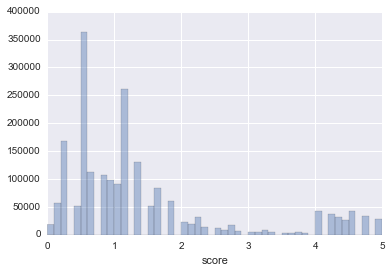

In [55]:
# Plot score distribution
seaborn.distplot(integrated_df['score'], kde=False);